# 通过AutoEncoder实现时序数据异常检测


本示例教程将会演示如何使用飞桨PaddlePaddle2.0来完成时序异常检测任务。这是一个较为简单的示例，将会搭建一个AutoEncoder网络完成任务。

本教程基于paddle-2.0-beta编写，如果您的环境不是本版本，请先安装paddle-2.0-beta版本。


## 环境配置

本教程基于paddle-2.0-beta编写，如果您的环境不是本版本，请先安装paddle-2.0-beta版本。

In [ ]:
#安装Paddle-2.0-beta版本
!pip install paddlepaddle-gpu==2.0.0b0

Looking in indexes: https://mirror.baidu.com/pypi/simple/
     |████████████████████████████████| 468.2MB 5.4MB/s eta 0:00:013     |███████████                     | 160.4MB 8.3MB/s eta 0:00:38     |███████████▌                    | 169.0MB 9.6MB/s eta 0:00:32     |██████████████▉                 | 217.8MB 8.1MB/s eta 0:00:31
  Created wheel for netifaces: filename=netifaces-0.10.9-cp37-cp37m-linux_x86_64.whl size=37349 sha256=5c8cd5d5eebba1bc1fca4395bd86f8b51fc4fb0f9f257901d740f978e15a4f90
  Stored in directory: /home/aistudio/.cache/pip/wheels/17/d5/84/2869e3e8344a6e634741ead2534e1c118cd2ebd7af39355423
Successfully built netifaces
  Found existing installation: paddlepaddle-gpu 1.8.4.post97
    Uninstalling paddlepaddle-gpu-1.8.4.post97:
      Successfully uninstalled paddlepaddle-gpu-1.8.4.post97


In [1]:
#导入模块
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
import paddle
import paddle.nn.functional as F
print(paddle.__version__)

# 启动动态图训练模式
paddle.disable_static()

2.0.0-beta0


## 加载数据集

* 我们将使用纽伦塔异常基准(NAB)数据集。它提供人工时间序列数据，包含标记的异常行为周期。

* 我们将使用art_daily_small_noise.csv文件内数据进行训练，并使用art_day_jumpup.csv文件内数据进行测试。

* 该数据集的简单性使我们能够有效地演示异常检测。

In [ ]:
#解压数据集
%cd ~/

!unzip data/data55385/artificialNoAnomaly.zip && unzip data/data55385/artificialWithAnomaly.zip

/home/aistudio
Archive:  data/data55385/artificialNoAnomaly.zip
  inflating: artificialNoAnomaly/art_daily_no_noise.csv  
  inflating: artificialNoAnomaly/art_daily_perfect_square_wave.csv  
  inflating: artificialNoAnomaly/art_daily_small_noise.csv  
  inflating: artificialNoAnomaly/art_flatline.csv  
  inflating: artificialNoAnomaly/art_noisy.csv  
Archive:  data/data55385/artificialWithAnomaly.zip
  inflating: artificialWithAnomaly/art_daily_flatmiddle.csv  
  inflating: artificialWithAnomaly/art_daily_jumpsdown.csv  
  inflating: artificialWithAnomaly/art_daily_jumpsup.csv  
  inflating: artificialWithAnomaly/art_daily_nojump.csv  
  inflating: artificialWithAnomaly/art_increase_spike_density.csv  
  inflating: artificialWithAnomaly/art_load_balancer_spikes.csv  


In [3]:
#正常数据预览
df_small_noise_path = 'artificialNoAnomaly/art_daily_small_noise.csv'
df_small_noise = pd.read_csv(
    df_small_noise_path, parse_dates=True, index_col="timestamp"
)

#异常数据预览
df_daily_jumpsup_path = 'artificialWithAnomaly/art_daily_jumpsup.csv'
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_path, parse_dates=True, index_col="timestamp"
)
print(df_small_noise.head())

print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


##  数据可视化

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


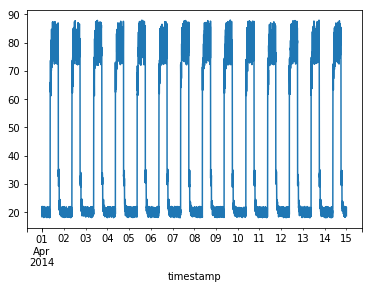

In [4]:
#正常的时序数据可视化
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()


带有异常的时序数据如下：
我们将使用以下数据进行测试，并查看数据中的突然跳升是否被检测为异常。

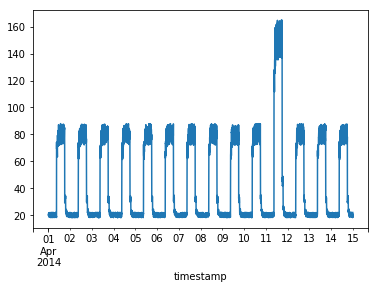

In [5]:
#异常的时序数据可视化
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

# 训练数据预处理

* 我们的训练数据包含了14天的采样，每天每隔5分钟采集一次数据，所以：
* 每天包含 24 * 60 / 5 = 288 个timestep 
* 总共14天 288 * 14 = 4032 个数据



In [6]:
#初始化并保存我们得到的均值和方差，用于初始化数据。
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("训练数据总量:", len(df_training_value))

训练数据总量: 4032


# 创建序列

从训练数据中创建组合时间步骤为288的连续数据值的序列。


In [7]:
#时序步长
TIME_STEPS = 288    

class MyDataset(paddle.io.Dataset):
    """
    步骤一：继承paddle.io.Dataset类
    """
    def __init__(self,data,time_steps):
        """
        步骤二：实现构造函数，定义数据读取方式，划分训练和测试数据集
        注意：我们这个是不需要label的哦
        """
        super(MyDataset, self).__init__()
        self.time_steps = time_steps
        self.data = paddle.to_tensor(self.transform(data),dtype='float32')

    def transform(self,data):
        '''
        构造时序数据
        '''
        output = []
        for i in range(len(data) - self.time_steps):
            output.append(np.reshape(data[i : (i + self.time_steps)],(1,self.time_steps)))
        return np.stack(output)

    def __getitem__(self, index):
        """
        步骤三：实现__getitem__方法，定义指定index时如何获取数据，并返回单条数据（训练数据）
        """
        data = self.data[index]
        label = self.data[index]
        return data,label

    def __len__(self):
        """
        步骤四：实现__len__方法，返回数据集总数目
        """
        return len(self.data)

# 实例化数据集
train_dataset = MyDataset(df_training_value.values,TIME_STEPS)


## 模型组网

用paddle.nn下的API，Layer,Conv1d、rlue完成网络的搭建。

In [9]:

class AutoEncoder(paddle.nn.Layer):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.conv0 = paddle.nn.Conv1d(in_channels=1,out_channels=32,kernel_size=7,stride=2)
        self.conv1 = paddle.nn.Conv1d(in_channels=32,out_channels=16,kernel_size=7,stride=2)
        self.convT0 = paddle.nn.ConvTranspose1d(in_channels=16,out_channels=32,kernel_size=7,stride=2)
        self.convT1 = paddle.nn.ConvTranspose1d(in_channels=32,out_channels=1,kernel_size=7,stride=2)

    def forward(self, x):
        x = self.conv0(x)
        x = F.relu(x)
        x = F.dropout(x,0.2)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.convT0(x)
        x = F.relu(x)
        x = F.dropout(x,0.2)
        x = self.convT1(x)
        return x

## 模型训练

接下来，我们用一个循环来进行模型的训练，我们将会：

- 使用paddle.optimizer.Adam优化器来进行优化。

- 使用paddle.nn.loss.MSELoss来计算损失值。 

- 使用paddle.io.DataLoader来加载数据并组建batch。


训练开始
epoch: 0, batch_id: 0, loss is: [1.0041192]
epoch: 1, batch_id: 0, loss is: [0.14454477]
epoch: 2, batch_id: 0, loss is: [0.09857777]
epoch: 3, batch_id: 0, loss is: [0.08679288]
epoch: 4, batch_id: 0, loss is: [0.08009232]
epoch: 5, batch_id: 0, loss is: [0.07222185]
epoch: 6, batch_id: 0, loss is: [0.06600908]
epoch: 7, batch_id: 0, loss is: [0.06039692]
epoch: 8, batch_id: 0, loss is: [0.05287679]
epoch: 9, batch_id: 0, loss is: [0.0468189]
epoch: 10, batch_id: 0, loss is: [0.04166677]
epoch: 11, batch_id: 0, loss is: [0.03735146]
epoch: 12, batch_id: 0, loss is: [0.03495374]
epoch: 13, batch_id: 0, loss is: [0.03352676]
epoch: 14, batch_id: 0, loss is: [0.03175257]
epoch: 15, batch_id: 0, loss is: [0.03109691]
epoch: 16, batch_id: 0, loss is: [0.02850873]
epoch: 17, batch_id: 0, loss is: [0.02944668]
epoch: 18, batch_id: 0, loss is: [0.02778028]
epoch: 19, batch_id: 0, loss is: [0.02723593]
epoch: 20, batch_id: 0, loss is: [0.02562439]
epoch: 21, batch_id: 0, loss is: [0.02540

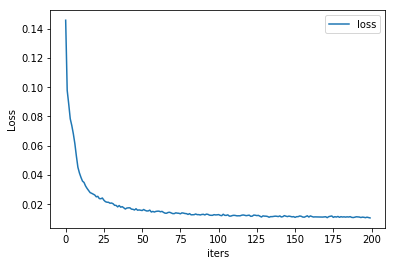

In [10]:
#参数设置
epoch_num = 200
batch_size = 128
learning_rate = 0.001

def train():
    print('训练开始')
    #实例化模型
    model = AutoEncoder()
    #将模型转换为训练模式
    model.train()
    #设置优化器，学习率，并且把模型参数给优化器
    opt = paddle.optimizer.Adam(learning_rate=learning_rate,parameters=model.parameters())
    #设置损失函数
    mse_loss = paddle.nn.loss.MSELoss()
    #设置数据读取器
    data_reader = paddle.io.DataLoader(train_dataset,
                        places=[paddle.CPUPlace()],
                        batch_size=batch_size,
                        shuffle=True,
                        drop_last=True,
                        num_workers=0)
    history_loss = []
    iter_epoch = []
    for epoch in range(epoch_num):
            for batch_id, data in enumerate(data_reader()):             
                x = data[0]
                y = data[1]
                out = model(x)
                avg_loss = mse_loss(out,(y[:,:,:-1]))   #输输入的数据进过卷积会丢掉最后一个数据所以只剩287
                if batch_id % 1000 == 0:
                    print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, avg_loss.numpy()))
                avg_loss.backward()
                opt.step()
                opt.clear_grad()
            iter_epoch.append(epoch)
            history_loss.append(avg_loss.numpy()[0])
    #绘制loss
    plt.plot(iter_epoch,history_loss, label = 'loss')
    plt.legend()
    plt.xlabel('iters')
    plt.ylabel('Loss')
    plt.show()
    #保存模型参数
    paddle.fluid.dygraph.save_dygraph(model.state_dict(),'model')

train()

## 探测异常时序

我们将用我们训练好的模型探测异常时序：

1. 使用自编码器计算出无异常时序数据集里的所有重建损失

2. 找出最大重建损失并且以这个为阀值，模型重建损失超出这个值则输入的数据为异常时序 



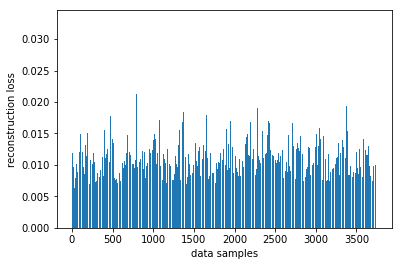

阀值: 0.03291812


In [27]:
#计算阀值

param_dict,_ = paddle.fluid.load_dygraph('model.pdparams')   #读取保存的参数
model = AutoEncoder()    
model.load_dict(param_dict)    #加载参数
model.eval()   #预测
total_loss = []
datas = []
#预测所有正常时序
mse_loss = paddle.nn.loss.MSELoss()
#这里设置batch_size为1，单独求得每个数据的loss
data_reader = paddle.io.DataLoader(train_dataset,
                        places=[paddle.CPUPlace()],
                        batch_size=1,
                        shuffle=False,
                        drop_last=False,
                        num_workers=0)
for batch_id, data in enumerate(data_reader()):
    x = data[0]
    y = data[1]
    out = model(x)
    avg_loss = mse_loss(out,(y[:,:,:-1]))
    total_loss.append(avg_loss.numpy()[0])
    datas.append(batch_id)

plt.bar(datas, total_loss)
plt.ylabel("reconstruction loss")
plt.xlabel("data samples")
plt.show()

# 获取重建loss的阀值.
threshold = np.max(total_loss)
print("阀值:", threshold)

## AutoEncoder 对异常数据的重构

为了好玩，让我们先看看我们的模型是如何重构第一个组数据。这是我们训练数据集第一天起的288步时间。

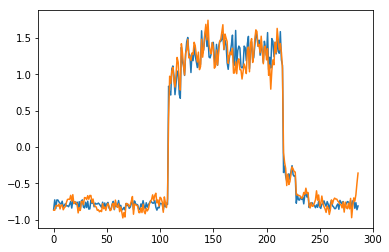

SystemExit: 

In [23]:
import sys
param_dict,_ = paddle.fluid.load_dygraph('model.pdparams')   #读取保存的参数
model = AutoEncoder()    
model.load_dict(param_dict)    #加载参数
model.eval()   #预测
data_reader = paddle.io.DataLoader(train_dataset,
                        places=[paddle.CPUPlace()],
                        batch_size=128,
                        shuffle=False,
                        drop_last=False,
                        num_workers=0)
for batch_id, data in enumerate(data_reader()):
    x = data[0]
    out = model(x)
    step = np.arange(287)
    plt.plot(step,x[0,0,:-1].numpy())
    plt.plot(step,out[0,0].numpy())
    plt.show()
    sys.exit()


* 可以看出对正常数据的重构效果十分不错
* 接下来我们对异常数据进行探测



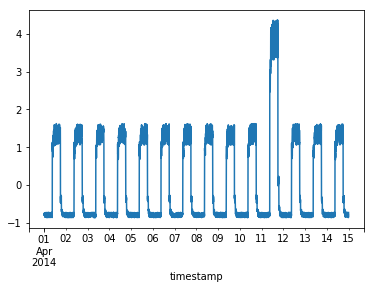

In [24]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()
#这是测试集里面的异常数据，可以看到第11~~12天发生了异常

In [28]:
#探测异常数据
threshold = 0.033    #阀值设定，即刚才求得的值
param_dict,_ = paddle.fluid.load_dygraph('model.pdparams')   #读取保存的参数
model = AutoEncoder()    
model.load_dict(param_dict)    #加载参数
model.eval()   #预测
mse_loss = paddle.nn.loss.MSELoss()

def create_sequences(values, time_steps=288):
    '''
    探测数据预处理
    '''
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_test = create_sequences(df_test_value.values)
x = paddle.to_tensor(x_test).astype('float32')

abnormal_index = [] #记录检测到异常时数据的索引

for i in range(len(x_test)):
    input_x = paddle.reshape(x[i],(1,1,288))
    out = model(input_x)
    loss = mse_loss(input_x[:,:,:-1],out)
    if loss.numpy()[0]>threshold:
        #开始检测到异常时序列末端靠近异常点，所以我们要加上序列长度，得到真实索引位置
        abnormal_index.append(i+288)

#不再检测异常时序列的前端靠近异常点，所以我们要减去索引长度得到异常点真实索引，为了结果明显，我们给异常位置加宽40单位
abnormal_index = abnormal_index[:(-288+40)]
print(len(abnormal_index))
print(abnormal_index)


142
[2990, 2991, 2992, 2993, 2994, 2995, 2997, 2998, 3000, 3001, 3002, 3003, 3004, 3005, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, 3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3101, 3102, 3103, 3104, 3105, 3106, 3107, 3108, 3109, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132, 3133, 3134]


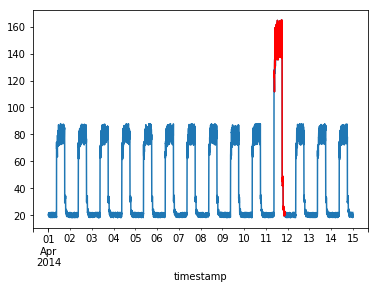

In [29]:
#异常检测结果可视化
df_subset = df_daily_jumpsup.iloc[abnormal_index]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()